# Fine Tuning Transformer for MultiClass Text Classification
- Script Objective: The objective of this script is to fine tune BERT to be able to classify a news headline into the following categories:
  0. Others
  1. Participation matters
  2. have extra credit
  3. engaging lecture
  4. helpful office hour
  5. heavy workload


# GPU Prep

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Import Libraries

In [ ]:
!pip3 install transformers

In [ ]:
# Importing the libraries needed
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

# Data Prep

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

%matplotlib inline
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Read data
input_path = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/"
participation = pd.read_csv(input_path + "participation2_final.csv", names=["id", "sentence", "cat"], header=0)
bonus = pd.read_csv(input_path + "a23-Extra Credit.csv", names=["id", "sentence", "cat"], header=0)
lecture = pd.read_csv(input_path + "a12 - Funny Lectures.csv", names=["id", "sentence", "cat"], header=0)
office_hour = pd.read_csv(input_path + "a3 - helpful office hour.csv", names=["id", "sentence", "cat"], header=0) 
other = pd.read_excel(input_path + "other.xlsx", names=["id", "sentence", "cat"], header=0)
workload = pd.read_excel(input_path + "workload.xlsx", names=["id", "sentence", "cat"], header=0)


# Remove unlabeled data
participation = participation[:243]
participation["cat"] = participation["cat"].fillna(0)
participation.loc[participation["cat"] == 1, "cat"] = 1

bonus["cat"] = bonus["cat"].fillna(0)
bonus.loc[bonus["cat"] == 1, "cat"] = 2

lecture["cat"] = lecture["cat"].fillna(0)
lecture.loc[lecture["cat"] == 2, "cat"] = 3

office_hour = office_hour[:180]
office_hour["cat"] = office_hour["cat"].fillna(0)
office_hour.loc[office_hour["cat"] == 3, "cat"] = 4

workload["cat"] = workload["cat"].fillna(0)
workload.loc[workload["cat"] == 1, "cat"] = 5

other = other[:200]
other.loc[other["cat"] == 1, "cat"] = 0
other = other.loc[other["cat"] == 0, :]


data = pd.concat([participation, bonus, lecture, office_hour, workload, other]).reset_index().drop(["index", "id"], axis=1)
data["cat"].value_counts()

0.0    448
3.0    288
2.0    185
4.0    157
1.0    127
5.0    125
Name: cat, dtype: int64

In [ ]:
data.head()

,sentence,cat
0,"As long as you do the work, participate in cla...",1.0
1,"Summers is the man, and as long as you show up...",1.0
2,"For tests, just know the review guide and whic...",0.0
3,Come to class and you will be fine.,1.0
4,Classes were lecture heavy - study them and yo...,1.0


## Dataloader and Dataset Prep

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 64
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 6
EPOCHS = 8
LEARNING_RATE = 8e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.sentence[index])
        sentence = " ".join(sentence.split())
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.cat[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8

train_dataset = data.sample(frac=train_size,random_state=2000)
validate_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATE Dataset: {}".format(validate_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
validating_set = Triage(validate_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1330, 2)
TRAIN Dataset: (1064, 2)
VALIDATE Dataset: (266, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validate_params = {'batch_size': VALID_BATCH_SIZE,
                   'shuffle': False,
                   'num_workers': 0
                   }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **validate_params)

# Build the Model

In [ ]:
import torch.nn as nn

class BertLSTMClass(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, input_ids, attention_mask):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
HIDDEN_DIM = 12
OUTPUT_DIM = 6
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6

bert = BertModel.from_pretrained('bert-base-uncased')
model = BertLSTMClass(bert,
                      HIDDEN_DIM,
                      OUTPUT_DIM,
                      N_LAYERS,
                      BIDIRECTIONAL,
                      DROPOUT)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,541,430 trainable parameters


In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 59,190 trainable parameters


In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


# Train the Model

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        predictions = model(ids, mask)
        loss = criterion(predictions, targets)
        
        big_val, big_idx = torch.max(predictions.data, dim=1)
        acc = calcuate_accu(big_idx, targets) / TRAIN_BATCH_SIZE
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            predictions = model(ids, mask).squeeze()
            loss = criterion(predictions, targets)
            
            big_val, big_idx = torch.max(predictions.data, dim=1)
            acc = calcuate_accu(big_idx, targets) / TRAIN_BATCH_SIZE

            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

n_epochs_stop = 3
epochs_no_improve = 0
early_stop = False

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, training_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, validating_loader, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    else:
        epochs_no_improve += 1
    
    # Early Stopping
    if epoch > 5 and epochs_no_improve == n_epochs_stop:
        print('Early stopping!' )
        early_stop = True
        break
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.622 | Train Acc: 35.11%
	 Val. Loss: 1.434 |  Val. Acc: 37.78%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 1.316 | Train Acc: 49.91%
	 Val. Loss: 1.105 |  Val. Acc: 53.70%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 1.062 | Train Acc: 61.89%
	 Val. Loss: 0.865 |  Val. Acc: 64.07%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.876 | Train Acc: 69.10%
	 Val. Loss: 0.690 |  Val. Acc: 74.07%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.776 | Train Acc: 73.50%
	 Val. Loss: 0.601 |  Val. Acc: 79.26%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.690 | Train Acc: 76.12%
	 Val. Loss: 0.520 |  Val. Acc: 82.22%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.596 | Train Acc: 80.81%
	 Val. Loss: 0.522 |  Val. Acc: 78.52%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.486 | Train Acc: 85.67%
	 Val. Loss: 0.547 |  Val. Acc: 80.00%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.471 | Train Acc: 84.36%
	 Val. Loss: 0.511 |  Val. Acc: 82.22%
Epoch: 10 | Epoch Time: 0m 7

## Validation Loss vs Training Loss

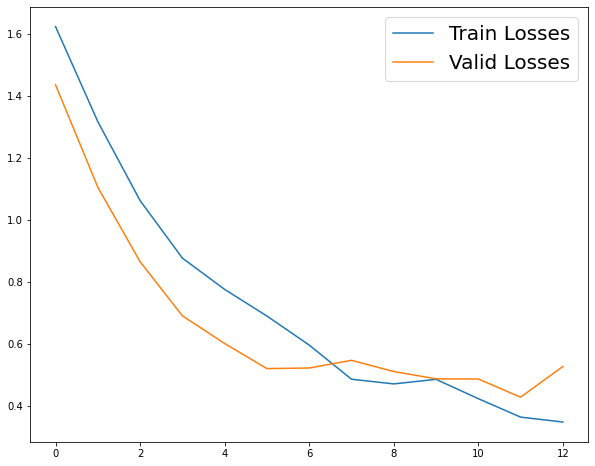

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

x = [i for i in range(len(train_losses))]
fig = plt.figure(figsize=(10, 8))
sns.lineplot(x=x, y=train_losses, label="Train Losses")
sns.lineplot(x=x, y=valid_losses, label="Valid Losses")
plt.legend(prop={'size': 20})

## Accuracy on Validation Set

In [ ]:
model = model.to(device)

In [ ]:
import time
print(time.time())

model.eval()
test_pred = torch.empty(0, dtype=torch.long, device="cuda")
for i, data in enumerate(validating_loader):
  ids = data['ids'].to(device, dtype = torch.long)
  mask = data['mask'].to(device, dtype = torch.long)
  pred = model(ids, mask)
  test_pred =  torch.cat((test_pred,pred),dim =0)
pred_val, pred_idx = torch.max(test_pred, dim=1)

print(time.time())

1617951135.0412557


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1617951135.689721


In [ ]:
validate_dataset["Prediction"] = pred_idx.cpu().numpy()

In [ ]:
print("Accuracy: ", sum(validate_dataset["cat"] == validate_dataset["Prediction"]) / len(validate_dataset))

Accuracy:  0.868421052631579


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(validate_dataset["cat"], validate_dataset["Prediction"])

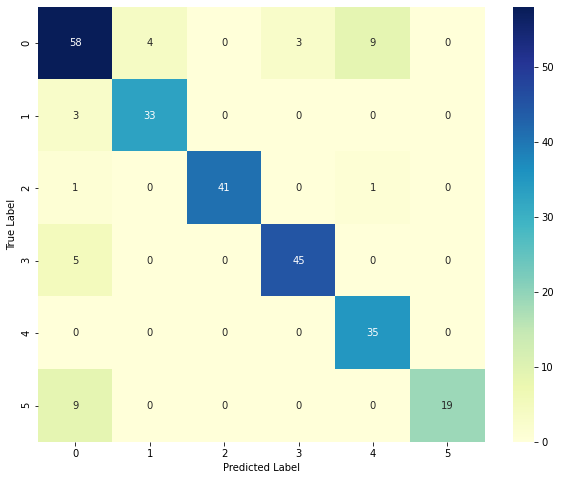

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(confusion, annot=True, cmap="YlGnBu");
plt.ylabel("True Label"); 
plt.xlabel("Predicted Label");

# Note the color scheme here is not optimal

# Generalize the model & Score Normalization

In [ ]:
from transformers import DistilBertModel

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.8)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]

        pooler = self.dropout2(pooler)
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)

        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.load_state_dict(torch.load('/content/drive/My Drive/Rebuild my Professor/models/classification_model.pt', map_location='cuda'))
model = model.to(device)

In [ ]:
import os
from tqdm import tqdm
import random
from nltk.tokenize import sent_tokenize
import nltk
import scipy
# nltk.download('punkt')

input_path = "/content/drive/My Drive/Rebuild my Professor/Ratings/"
files = [file for file in os.listdir(input_path) if file.endswith("csv")]
data = pd.DataFrame()
for file in tqdm(files):
  df = pd.read_csv(input_path + file, engine="python", index_col = 0)
  df = df[df.tid.isin(random.sample(set(df.tid.unique()),int(len(df.tid.unique()) / 20)))]
  data = data.append(df)

100%|██████████| 97/97 [01:07<00:00,  1.43it/s]


In [ ]:
tid_sample = data['tid'].value_counts()[(data['tid'].value_counts().values >= 30) & (data['tid'].value_counts().values < 1000)]
tid_sample = list(tid_sample.index)

In [ ]:
data = data[data.tid.isin(tid_sample)]

In [ ]:
model.eval()
scores = []
for tid in tqdm(tid_sample):
  sentences = list(data.loc[data.tid == tid, "rComments"])
  sentences = [sent for review in sentences if type(review)==str for sent in sent_tokenize(review)]
  sentences = pd.DataFrame({"sentence": sentences})
  sentences["cat"] = 0
  sentences_dict = Triage(sentences, tokenizer, MAX_LEN)
  sentences_loader = DataLoader(sentences_dict, **test_params)
  model.eval()
  test_pred = []
  for i, batch in enumerate(sentences_loader):
    ids = batch['ids'].to(device)
    mask = batch['mask'].to(device)
    pred = model(ids, mask)
    pred = pred.cpu().detach().numpy()
    test_pred.extend(pred)
  prof_scores = scipy.special.softmax(test_pred, axis=1).mean(axis=0)
  scores.append(prof_scores)

  0%|          | 0/1096 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  0%|          | 1/1096 [00:04<1:30:30,  4.96s/it]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max

In [ ]:
scores = np.array(scores)
with open('/content/drive/My Drive/Rebuild my Professor/scores.npy', 'wb') as f:
  np.save(f, scores)

Text(0.5, 1.0, 'Workload')

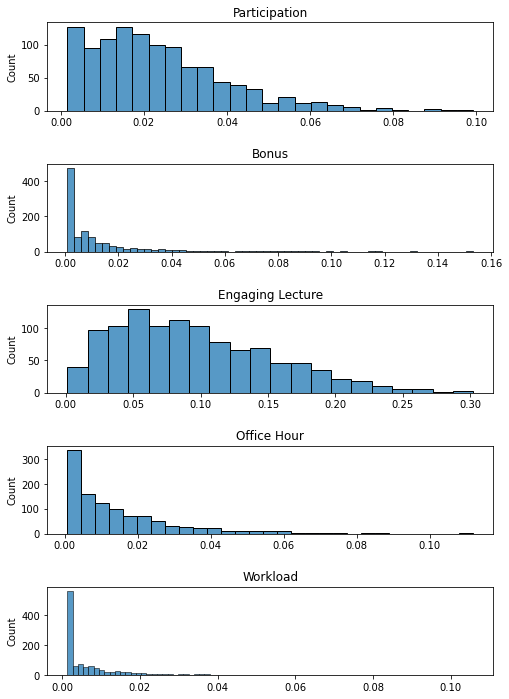

In [ ]:
import matplotlib as mpl
%matplotlib inline
fig, axes = plt.subplots(5, 1, figsize=(8, 12))
wspace = 0.2 
hspace = 0.6
plt.subplots_adjust(wspace=wspace, hspace=hspace)
sns.histplot(x=scores[:, 1], ax=axes[0])
sns.histplot(x=scores[:, 2], ax=axes[1])
sns.histplot(x=scores[:, 3], ax=axes[2])
sns.histplot(x=scores[:, 4], ax=axes[3])
sns.histplot(x=scores[:, 5], ax=axes[4])
axes[0].set_title("Participation")
axes[1].set_title("Bonus")
axes[2].set_title("Engaging Lecture")
axes[3].set_title("Office Hour")
axes[4].set_title("Workload")

In [ ]:
with open('/content/drive/My Drive/Rebuild my Professor/scores.npy', 'rb') as f:
  scores = np.load(f)

In [ ]:
model.eval()

sentence = "He is fantastic"
sentence = " ".join(sentence.split())
inputs = tokenizer.encode_plus(
    sentence,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    pad_to_max_length=True,
    return_token_type_ids=True,
    truncation=True
)
ids = inputs['input_ids']
mask = inputs['attention_mask']

ids = torch.tensor(ids, dtype=torch.long).to(device, dtype=torch.long).unsqueeze(0)
mask = torch.tensor(mask, dtype=torch.long).to(device, dtype=torch.long).unsqueeze(0)
outputs = model(ids, mask).squeeze()
outputs = outputs.cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
prof_scores = np.array(scores)[0]

In [ ]:
0.2 + (1-0.2) * (sum(scores[:, 1] < prof_scores[1]) / scores.shape[0])

0.6343065693430657

In [ ]:
scores[:, 1] < prof_scores[1]

array([False,  True,  True, ...,  True, False, False])